In [108]:
from bettools import get_data, generate_seasons, calculate_poisson_match_outcomes, calculate_ev_from_odds, find_best_fit_goals
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None

In [109]:
# leagues = ['E0','E1','E2','E3','SC0','SC1','SC2','D1','D2','I1','I2','SP1','SP2','F1','F2','N1','B1','P1','T1','G1']

leagues = ['E0']

season_list = generate_seasons(2016, 2024)

df_ls = get_data(season_list, leagues, additional_cols=['HS','AS','HC','AC'])

In [110]:
main_df = pd.concat(df_ls)

home_games = main_df[['Date', 'HomeTeam', 'FTHG', 'HS', 'HC']].rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals', 'HS': 'Shots', 'HC': 'Corners'})

away_games = main_df[['Date', 'AwayTeam', 'FTAG', 'AS', 'AC']].rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals', 'AS': 'Shots', 'AC': 'Corners'})

all_games = pd.concat([home_games, away_games], ignore_index=True)

all_games.sort_values(['Team', 'Date'], inplace=True)

all_games['RollingMeanGoals'] = all_games.groupby('Team')['Goals'].transform(lambda x: x.shift().rolling(window=10).mean())
all_games['RollingMeanShots'] = all_games.groupby('Team')['Shots'].transform(lambda x: x.shift().rolling(window=10).mean())
all_games['RollingMeanCorners'] = all_games.groupby('Team')['Corners'].transform(lambda x: x.shift().rolling(window=25).mean())

main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals', 'RollingMeanShots','RollingMeanCorners']], left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanHomeGoals', 'RollingMeanShots': 'RollingMeanHomeShots', 'RollingMeanCorners': 'RollingMeanHomeCorners'}).drop('Team', axis=1)

main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals', 'RollingMeanShots','RollingMeanCorners']], left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanAwayGoals', 'RollingMeanShots': 'RollingMeanAwayShots', 'RollingMeanCorners':'RollingMeanAwayCorners'}).drop('Team', axis=1)

main_df = main_df.dropna()

main_df.reset_index(inplace=True, drop=True)

In [111]:
# Function to adjust for longshot bias
def adjust_for_longshot_bias(row):
    # Convert odds to initial probabilities
    initial_probs = np.array([1 / row['PSH'], 1 / row['PSD'], 1 / row['PSA']])
    
    # Calculate total initial probability (including overround)
    total_initial_prob = sum(initial_probs)
    
    # A simple approach: more weighting to longer odds (less likely outcomes)
    weights = initial_probs / total_initial_prob  # Use initial probabilities as weights
    adjusted_probs = initial_probs * (weights / np.sum(weights))
    
    # Normalize adjusted probabilities to ensure they sum to 1
    adjusted_probs /= np.sum(adjusted_probs)
    
    return pd.Series(adjusted_probs, index=['PinnacleProbHome', 'PinnacleProbDraw', 'PinnacleProbAway'])

# Calculate expected goals based on adjusted probabilities
def calculate_expected_goals_from_adjusted_probs(row):
    home_goals, away_goals = find_best_fit_goals(row['PinnacleProbHome'], row['PinnacleProbDraw'], row['PinnacleProbAway'])
    return pd.Series([home_goals, away_goals])

main_df[['PinnacleProbHome', 'PinnacleProbDraw', 'PinnacleProbAway']] = main_df.apply(adjust_for_longshot_bias, axis=1)

main_df[['HomeExpectedGoals', 'AwayExpectedGoals']] = main_df.apply(calculate_expected_goals_from_adjusted_probs, axis=1)

In [113]:
total_rows = len(main_df)
split_point = int(total_rows * 0.8)

train_df = main_df.iloc[:split_point]
test_df = main_df.iloc[split_point:]

In [114]:
# For home predictions
X_home_train = train_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots', 'HomeExpectedGoals']]
y_home_train = train_df['FTHG']

X_home_test = test_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots', 'HomeExpectedGoals']]
y_home_test = test_df['FTHG']

# For away predictions
X_away_train = train_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots', 'AwayExpectedGoals']]
y_away_train = train_df['FTAG']

X_away_test = test_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots', 'AwayExpectedGoals']]
y_away_test = test_df['FTAG']

# Home model
model_home = LinearRegression()
model_home.fit(X_home_train, y_home_train)

# Away model
model_away = LinearRegression()
model_away.fit(X_away_train, y_away_train)

# Predictions for home and away
y_home_pred = model_home.predict(X_home_test)
y_away_pred = model_away.predict(X_away_test)

In [115]:
# Evaluation for home model
mse_home = mean_squared_error(y_home_test, y_home_pred)
r2_home = r2_score(y_home_test, y_home_pred)

# Evaluation for away model
mse_away = mean_squared_error(y_away_test, y_away_pred)
r2_away = r2_score(y_away_test, y_away_pred)

print("Home Model MSE:", mse_home)
print("Home Model R-squared:", r2_home)
print("Away Model MSE:", mse_away)
print("Away Model R-squared:", r2_away)

Home Model MSE: 1.5249922963349174
Home Model R-squared: 0.13516292062302027
Away Model MSE: 1.4144996700245271
Away Model R-squared: 0.13309289112838374


In [116]:
test_df['PredictedFTHG'] = y_home_pred
test_df['PredictedFTAG'] = y_away_pred

In [117]:
results = test_df.apply(lambda x: calculate_poisson_match_outcomes(x['PredictedFTHG'], x['PredictedFTAG']), axis=1)

test_df['home_win_prob'], test_df['draw_prob'], test_df['away_win_prob'] = zip(*results)

<Axes: title={'center': 'Home Betting at Best KO Odds'}>

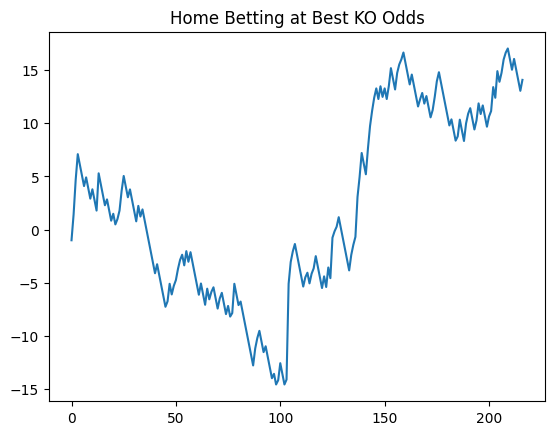

In [118]:
test_df['home_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['home_win_prob']), axis=1)
test_df['away_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['away_win_prob']), axis=1)
# test_df['draw_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['draw_max_odds'], x['draw_prob']), axis=1)

HOME_MIN_THRESH = 0
HOME_MAX_THRESH = 0.2

home_bet_df = test_df[(test_df['home_ev']>HOME_MIN_THRESH)&(test_df['home_ev']<HOME_MAX_THRESH)]
home_bet_df.reset_index(inplace=True, drop=True)
home_bet_df['profit'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'], home_bet_df['home_max_odds']-1, -1)
home_bet_df['c_profit'] = home_bet_df['profit'].cumsum()
home_bet_df['c_profit'].plot(title='Home Betting at Best KO Odds')

<Axes: >

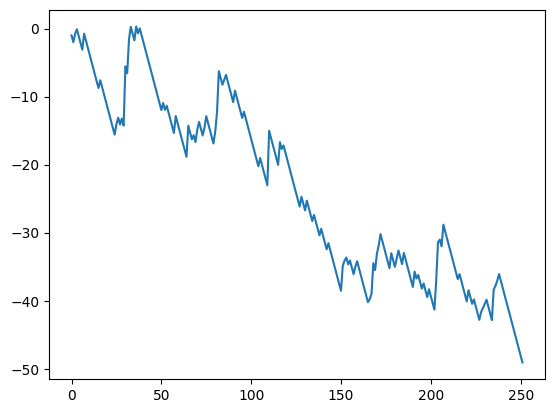

In [120]:
AWAY_MIN_THRESH = 0
AWAY_MAX_THRESH = 1

away_bet_df = test_df[(test_df['away_ev']>AWAY_MIN_THRESH)&(test_df['away_ev']<AWAY_MAX_THRESH)]
away_bet_df.reset_index(inplace=True, drop=True)
away_bet_df['profit'] = np.where(away_bet_df['FTAG']>away_bet_df['FTHG'], away_bet_df['away_max_odds']-1, -1)
away_bet_df['c_profit'] = away_bet_df['profit'].cumsum()
away_bet_df['c_profit'].plot()

In [ ]:
## trying it with poisson regression - which is better suited to this

# For home predictions - Poisson Regression
X_home_train = train_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
X_home_train = sm.add_constant(X_home_train)  # Adds a constant term to the predictor variables
y_home_train = train_df['FTHG']

X_home_test = test_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
X_home_test = sm.add_constant(X_home_test)  # Also add constant to the test data

# For away predictions - Poisson Regression
X_away_train = train_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
X_away_train = sm.add_constant(X_away_train)  # Adds a constant term to the predictor variables
y_away_train = train_df['FTAG']

X_away_test = test_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
X_away_test = sm.add_constant(X_away_test)  # Also add constant to the test data

# Fitting the Poisson regression model for home data
model_home = sm.GLM(y_home_train, X_home_train, family=sm.families.Poisson()).fit()

# Fitting the Poisson regression model for away data
model_away = sm.GLM(y_away_train, X_away_train, family=sm.families.Poisson()).fit()

# Predictions for home and away - note that predictions will be on the scale of the linear predictor
# i.e., the log of the expected counts. To get expected counts, use np.exp() on predictions.
y_home_pred = model_home.predict(X_home_test)
y_home_pred_counts = np.exp(y_home_pred)  # Convert log predictions to expected counts

y_away_pred = model_away.predict(X_away_test)
y_away_pred_counts = np.exp(y_away_pred)  # Convert log predictions to expected counts

In [ ]:
test_df['PredictedFTHG'] = y_home_pred_counts
test_df['PredictedFTAG'] = y_away_pred_counts

In [ ]:
results = test_df.apply(lambda x: calculate_poisson_match_outcomes(x['PredictedFTHG'], x['PredictedFTAG']), axis=1)

test_df['home_win_prob'], test_df['draw_prob'], test_df['away_win_prob'] = zip(*results)

In [ ]:
test_df['home_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['home_win_prob']), axis=1)
test_df['away_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['away_win_prob']), axis=1)

HOME_MIN_THRESH = 0.1
HOME_MAX_THRESH = 0.4

home_bet_df = test_df[(test_df['home_ev']>HOME_MIN_THRESH)&(test_df['home_ev']<HOME_MAX_THRESH)]
home_bet_df.reset_index(inplace=True, drop=True)
home_bet_df['profit'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'], home_bet_df['home_max_odds']-1, -1)
home_bet_df['c_profit'] = home_bet_df['profit'].cumsum()
home_bet_df['c_profit'].plot(title='Home Betting at Best KO Odds')

In [ ]:
AWAY_MIN_THRESH = 0.0
AWAY_MAX_THRESH = 0.2

away_bet_df = test_df[(test_df['away_ev']>AWAY_MIN_THRESH)&(test_df['away_ev']<AWAY_MAX_THRESH)]
away_bet_df.reset_index(inplace=True, drop=True)
away_bet_df['profit'] = np.where(away_bet_df['FTAG']>away_bet_df['FTHG'], away_bet_df['away_max_odds']-1, -1)
away_bet_df['c_profit'] = away_bet_df['profit'].cumsum()
away_bet_df['c_profit'].plot()

In [ ]:
test_df.FTHG.mean()

In [ ]:
test_df.PredictedFTHG.mean()

In [ ]:
pearson_resid = model_home.resid_pearson
phi = np.sum(pearson_resid**2) / model_home.df_resid

print(f"Dispersion statistic (phi): {phi}")

In [ ]:
pearson_resid = model_away.resid_pearson
phi = np.sum(pearson_resid**2) / model_away.df_resid

print(f"Dispersion statistic (phi): {phi}")

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson, Poisson

# Assuming X and y are your predictors and response variable, respectively
# Fit a standard Poisson model
model_poisson = Poisson(y_home_train, X_home_train).fit()

# Fit a Zero-Inflated Poisson (ZIP) model
model_zip = ZeroInflatedPoisson(y_home_train, X_home_train, exog_infl=X_home_train).fit(method='bfgs', maxiter=100000)

# Compare AIC and BIC
print(f"Poisson AIC: {model_poisson.aic}, BIC: {model_poisson.bic}")
print(f"ZIP AIC: {model_zip.aic}, BIC: {model_zip.bic}")

# You might also compare the log-likelihood
print(f"Poisson Log-Likelihood: {model_poisson.llf}")
print(f"ZIP Log-Likelihood: {model_zip.llf}")


In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Initialize two separate scalers for home and away data
scaler_home = StandardScaler()
scaler_away = StandardScaler()

# Prepare and scale the training data for home predictions
X_home_train_raw = train_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
X_home_train_scaled = scaler_home.fit_transform(X_home_train_raw)
X_home_train_scaled = sm.add_constant(X_home_train_scaled)  # Add the constant term after scaling

# Prepare and scale the training data for away predictions
X_away_train_raw = train_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
X_away_train_scaled = scaler_away.fit_transform(X_away_train_raw)
X_away_train_scaled = sm.add_constant(X_away_train_scaled)  # Add the constant term after scaling

# Scale the test data using the respective scalers
X_home_test_raw = test_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
X_home_test_scaled = scaler_home.transform(X_home_test_raw)
X_home_test_scaled = sm.add_constant(X_home_test_scaled)  # Add the constant term after scaling

X_away_test_raw = test_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
X_away_test_scaled = scaler_away.transform(X_away_test_raw)
X_away_test_scaled = sm.add_constant(X_away_test_scaled)  # Add the constant term after scaling

# Fit the Poisson regression models using the scaled data
model_home = sm.GLM(y_home_train, X_home_train_scaled, family=sm.families.Poisson()).fit()
model_away = sm.GLM(y_away_train, X_away_train_scaled, family=sm.families.Poisson()).fit()

# Make predictions using the scaled test data
y_home_pred = model_home.predict(X_home_test_scaled)
y_away_pred = model_away.predict(X_away_test_scaled)

# Convert log predictions to expected counts
y_home_pred_counts = np.exp(y_home_pred)
y_away_pred_counts = np.exp(y_away_pred)

In [ ]:
y_home_pred_counts.mean()